In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import  solve_ivp
from scipy.optimize import differential_evolution
import math
import matplotlib.pyplot as plt 
import sys
import os
        

In [2]:
path = 'data/'

dt = 0.01
tfinal = 50
times = np.arange(0,tfinal+dt,dt)

S0 = 90082.0
I0 = 203.0 #203
R0 = 0.0

In [3]:
def odeSystem(t, u, beta, alpha):

    S, I, R = u
    dS_dt = - beta*S*I 
    dI_dt = beta*S*I - alpha*I
    dR_dt = alpha*I

    return [dS_dt, dI_dt, dR_dt]  

def isReferenceTime(times, ct):
    for t in times: 
        if (abs(ct - t) <= 10**(-5)):
            return True 
    return False

def solve(x):
    global data, reference_times

    u = [S0, I0, R0]

    beta = x[0]
    alpha = x[1]
    params = (beta, alpha)
    
    def solveOde(t, y):
        return odeSystem(t, y, *params)

    results = solve_ivp(solveOde,(0, tfinal), u, t_eval=times, method='RK45')    

    u = results.y[1,:]
    error = 0
    sumobs = 0
    i = 0
    j = 0    
    for t in times:
        if isReferenceTime(reference_times,t):
            p_data = data["I"][i]
            error += (u[j] - p_data)*(u[j] - p_data) 
            sumobs += p_data*p_data
            i = i + 1
        j = j + 1

    error = math.sqrt(error/sumobs) #Erro norma 2                  
    return error 

In [4]:
#global data, reference_times 
data = pd.read_csv(path+'I.csv', delimiter=',')
reference_times = data["Semana"]
dados_I = data["I"]

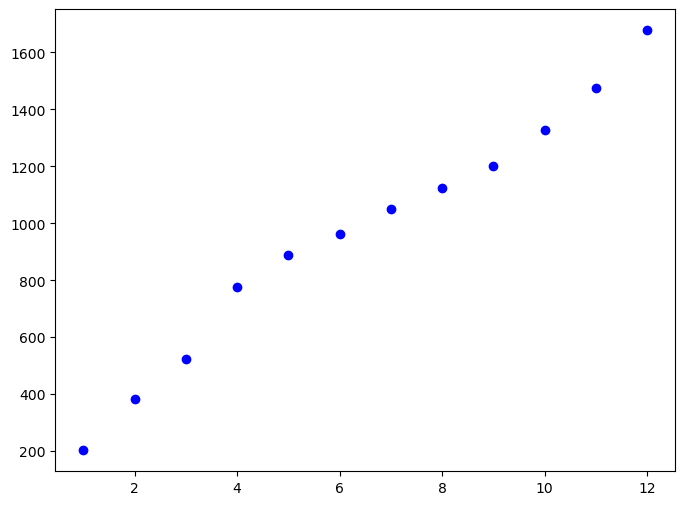

In [11]:
#plota os dados experimentais 
fig1 = plt.figure()
fig1.set_size_inches(8, 6)
plt.scatter(reference_times, dados_I, marker='o', color='blue', label=r'I_{obs}')

In [10]:
bounds = [
    (0.00001, 0.02), (0, 0.85)
]


/usr/lib/python3/dist-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 11.7488
differential_evolution step 2: f(x)= 11.7488
differential_evolution step 3: f(x)= 11.6336
differential_evolution step 4: f(x)= 11.6336
differential_evolution step 5: f(x)= 11.6336
differential_evolution step 6: f(x)= 11.6336
differential_evolution step 7: f(x)= 11.6336
differential_evolution step 8: f(x)= 11.6336
differential_evolution step 9: f(x)= 11.6336
differential_evolution step 10: f(x)= 11.6336
differential_evolution step 11: f(x)= 11.6336
differential_evolution step 12: f(x)= 0.456094
differential_evolution step 13: f(x)= 0.456094
differential_evolution step 14: f(x)= 0.456094
differential_evolution step 15: f(x)= 0.456094
differential_evolution step 16: f(x)= 0.456094
differential_evolution step 17: f(x)= 0.456094
differential_evolution step 18: f(x)= 0.456094
differential_evolution step 19: f(x)= 0.456094
differential_evolution step 20: f(x)= 0.456094
differential_evolution step 21: f(x)= 0.283731
differential_evolution step 22: f

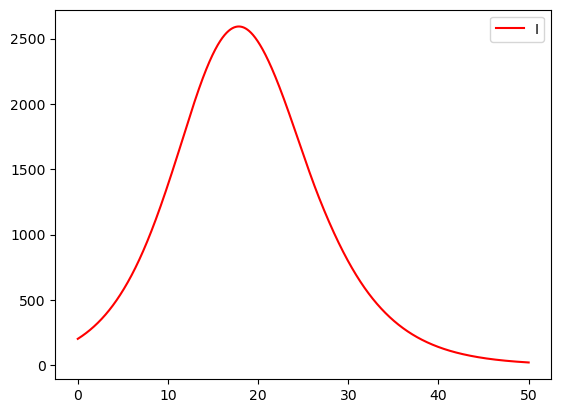

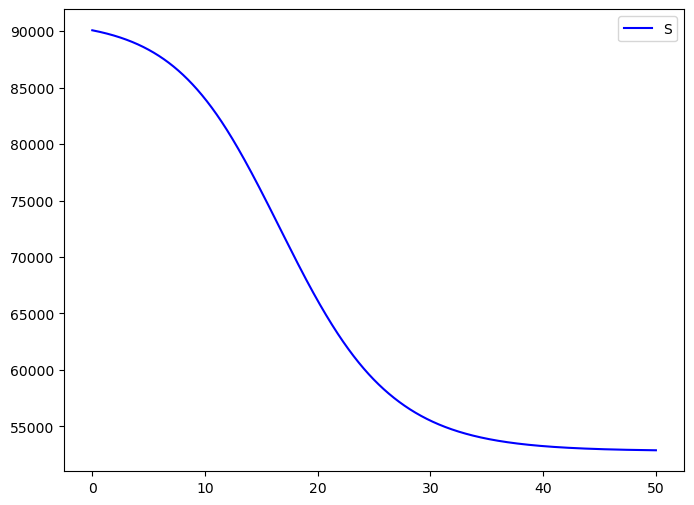

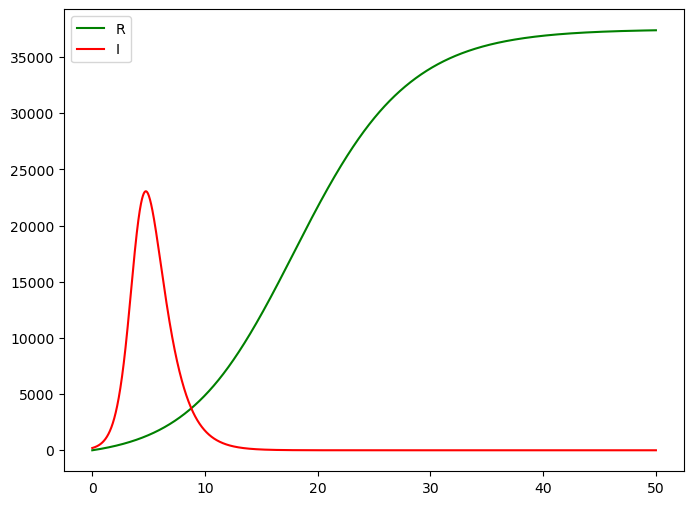

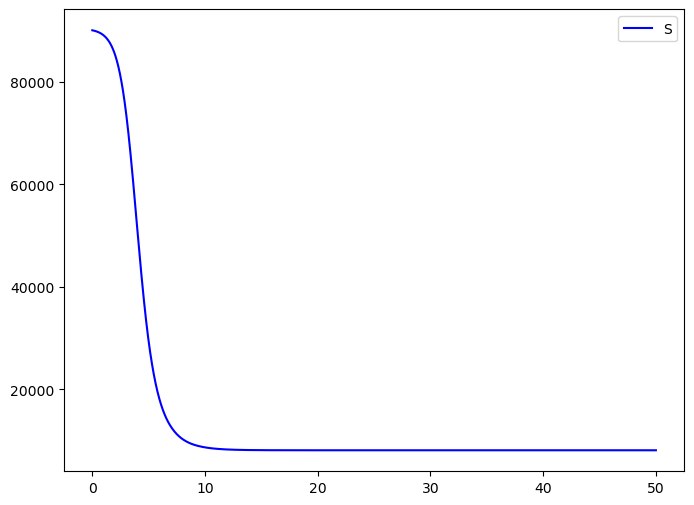

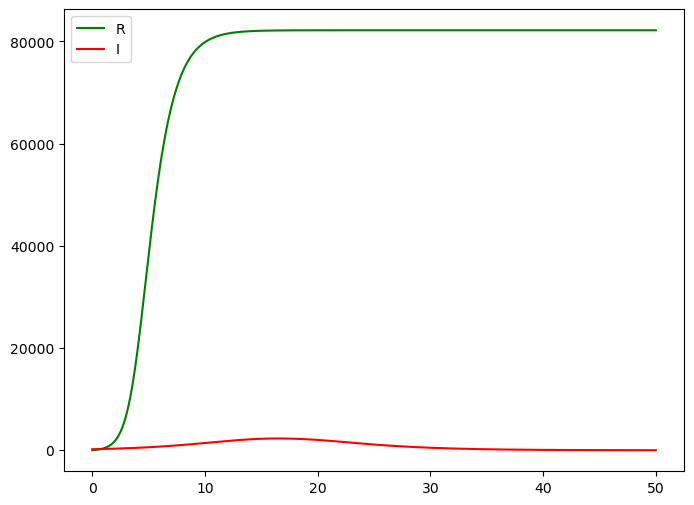

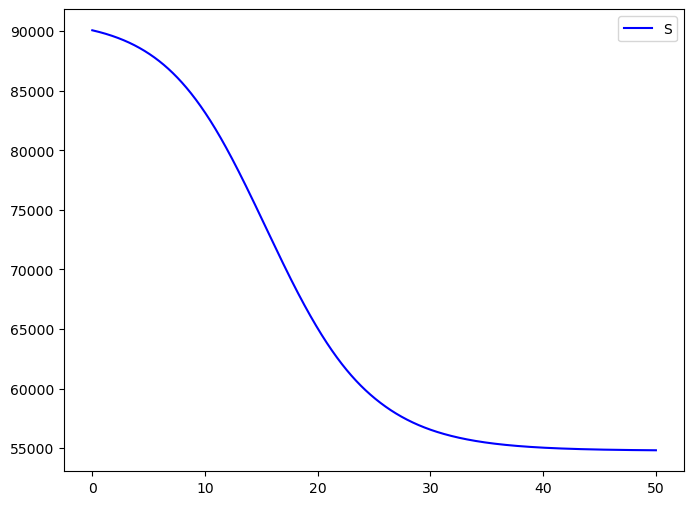

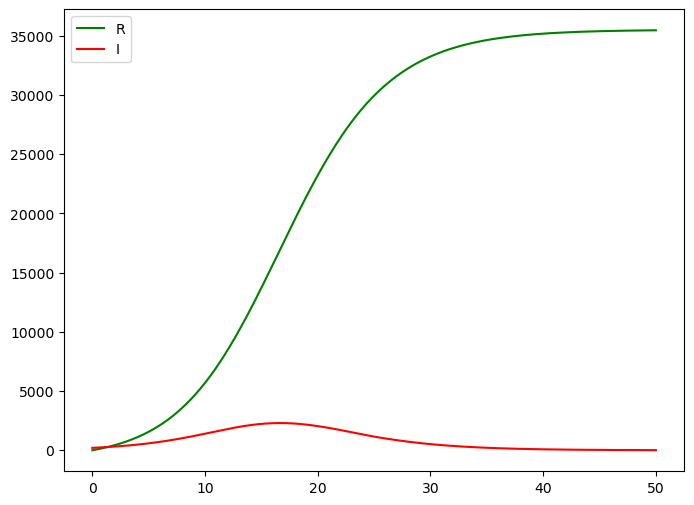

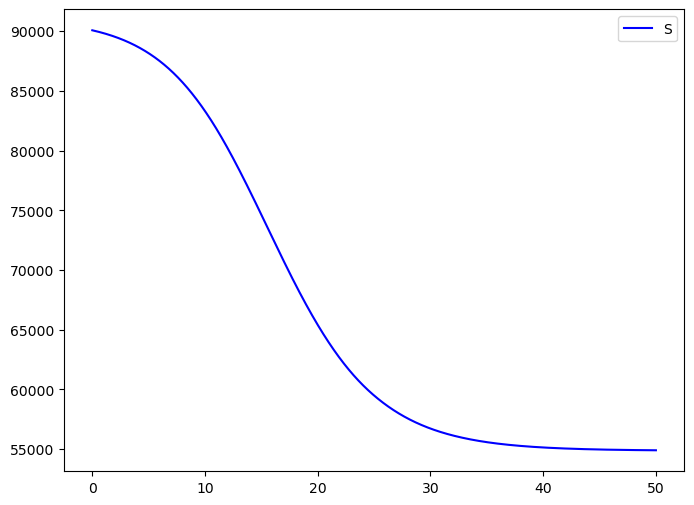

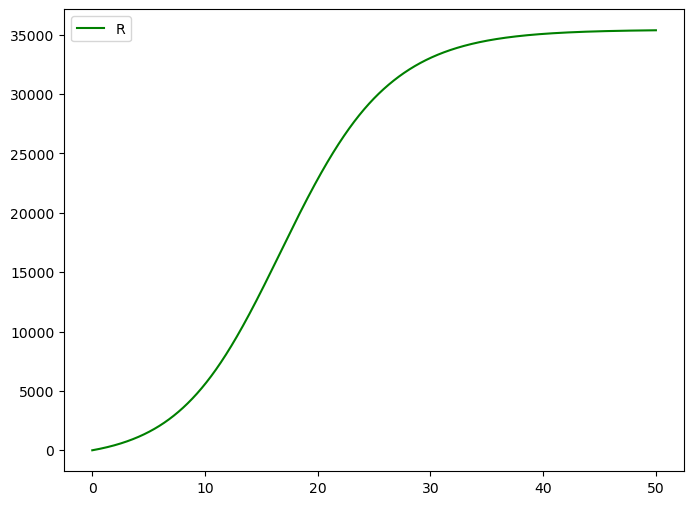

In [12]:
#chama evolução diferencial, result contém o melhor individuo
estrategias = ['rand2bin', 'rand2bin', 'best1bin', 'best2bin']
for estr in estrategias:
    solucao = differential_evolution(solve, bounds, strategy= estr, maxiter=50, popsize=40,atol=10**(-3), tol=10**(-3), mutation=0.8, recombination=0.5, disp=True, workers=4)

    print(solucao.x)
    #saving the best offspring...
    best = solucao.x
    error = solve(best)
    np.savetxt(f'solucao_ajuste.txt', solucao.x, fmt='%.8f')        
    print(error)
    #print("ERROR ", error)
    #print(solucao.population)
    #print(solucao.population_energies)

    u = [S0, I0, R0]
    result_best = solve_ivp(odeSystem,(0, tfinal+dt), u, t_eval=times, args=best, method='RK45')
    plt.plot(result_best.t, result_best.y[1,:], color='red', label=r'I')
    plt.legend(loc='best')    
    #fig.savefig(f'I.png', format='png')
    #plt.show()    
    #
    fig2 = plt.figure()
    fig2.set_size_inches(8, 6)
    plt.plot(result_best.t, result_best.y[0,:], color='blue', label=r'S')
    plt.legend(loc='best')
    #fig.savefig(f'S.png', format='png')
    #plt.show()
    
    fig3 = plt.figure()
    fig3.set_size_inches(8, 6)
    plt.plot(result_best.t, result_best.y[2,:], color='green', label=r'R')
    plt.legend(loc='best')
    #fig.savefig(f'R.png', format='png')
    #plt.show()

fig1.savefig(f'I.png', format='png')
fig2.savefig(f'S.png', format='png')
fig3.savefig(f'R.png', format='png')